In [1]:
import torch
from torch import nn

# Comparing the Different Configuration

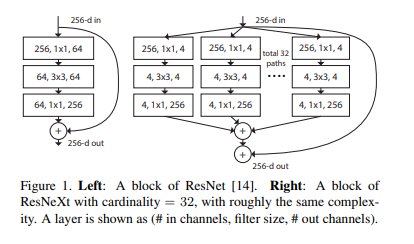

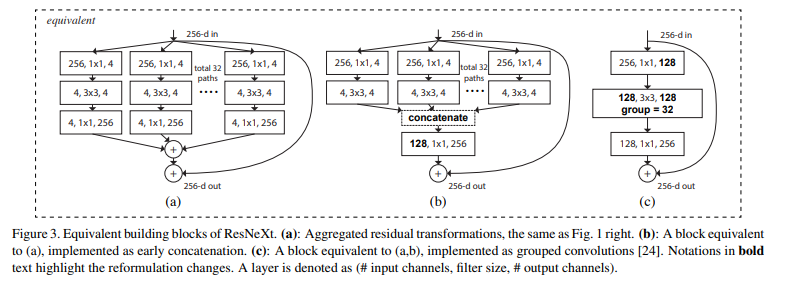

# ResNet BottleNeck Block

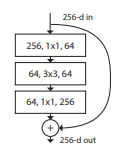


In [35]:
class BottleNeck(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(256,64,kernel_size=1,stride=1,padding=0,bias=False),
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1,bias=False),
            nn.Conv2d(64,256,kernel_size=1,stride=1,padding=0,bias=False)
        )
    def forward(self,x):
        y = self.block(x)
        y += x
        return y

In [36]:
sum(p.numel() for p in BottleNeck().parameters())

69632

In [46]:
BottleNeck()(torch.randn(size=(256,56,56))).shape

torch.Size([256, 56, 56])

# Aggregated Residual Transformation

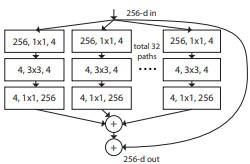

In [82]:
class AggTrans(nn.Module):
    def __init__(self,width) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(256,width,kernel_size=1,stride=1,padding=0,bias=False),
            nn.Conv2d(width,width,kernel_size=3,stride=1,padding=1,bias=False),
            nn.Conv2d(4,256,kernel_size=1,stride=1,padding=0,bias=False)
        )
    def forward(self,x):
        return self.block(x)

In [83]:
AggTrans(4)(torch.randn(size=(1,256,56,56))).shape

torch.Size([1, 256, 56, 56])

In [111]:
class ResidualAggTrans(nn.Module):
    def __init__(self,cardinality,width) -> None:
        super().__init__()
        self.cardinality = cardinality
        self.width = width
        for i in range(cardinality):
            setattr(self,f"res{i}",AggTrans(width))
    
    def forward(self,x):
        group = torch.stack([getattr(self,f"res{i}")(x) for i in range(self.cardinality)],dim=0)
        agg = group.sum(dim=0)
        # print(agg.shape)
        agg += x 
        return agg

In [112]:
sum(p.numel() for p in ResidualAggTrans(32,4).parameters())

70144

In [113]:
ResidualAggTrans(32,4)(torch.randn(size=(1,256,56,56))).shape

torch.Size([1, 256, 56, 56])

In [114]:
print(f"Number of parameter in the BottleNeck : {sum(p.numel() for p in BottleNeck().parameters())}")
print(f"Number of parameter in the ResAggTrans : {sum(p.numel() for p in ResidualAggTrans(32,4).parameters())}")

Number of parameter in the BottleNeck : 69632
Number of parameter in the ResAggTrans : 70144


# Equivalent to Inception

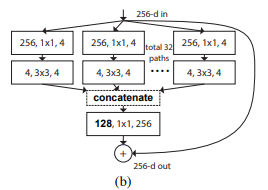

In [134]:
class InsAggTrans(nn.Module):
    def __init__(self,width) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(256,width,kernel_size=1,stride=1,padding=0,bias=False),
            nn.Conv2d(width,width,kernel_size=3,stride=1,padding=1,bias=False)
        )
    def forward(self,x):
        return self.block(x)

In [135]:
InsAggTrans(4)(torch.randn(size=(1,256,56,56))).shape

torch.Size([1, 4, 56, 56])

In [136]:
class InceptionEq(nn.Module):
    def __init__(self,cardinality,width) -> None:
        super().__init__()
        self.cardinality = cardinality
        self.width = width
        for i in range(cardinality):
            setattr(self,f"res{i}",InsAggTrans(width))
        self.conv1x1 = nn.Conv2d(cardinality*width,256,kernel_size=1,stride=1,padding=0,bias=False)
    
    def forward(self,x):
        group = [getattr(self,f"res{i}")(x)for i in range(self.cardinality)]
        # for a in group:
        #     print(a.shape)
        y = torch.cat(group,dim=1)
        y = self.conv1x1(y)
        y += x
        return y
         

In [137]:
InceptionEq(32,4)(torch.randn(size=(1,256,56,56))).shape

torch.Size([1, 256, 56, 56])

In [138]:
print(f"Number of parameter in the BottleNeck : {sum(p.numel() for p in BottleNeck().parameters())}")
print(f"Number of parameter in the ResAggTrans : {sum(p.numel() for p in ResidualAggTrans(32,4).parameters())}")
print(f"Number of parameter in the InceptionEq : {sum(p.numel() for p in InceptionEq(32,4).parameters())}")

Number of parameter in the BottleNeck : 69632
Number of parameter in the ResAggTrans : 70144
Number of parameter in the InceptionEq : 70144


# Grouped Convolution

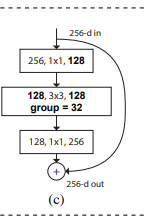

In [144]:
class GroupConv(nn.Module):
    def __init__(self,cardinality,width) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(256,cardinality*width,kernel_size=1,stride=1,padding=0,bias=False),
            nn.Conv2d(cardinality*width,cardinality*width,kernel_size=3,
                      groups=cardinality,stride=1,padding=1,bias=False),
            nn.Conv2d(cardinality*width,256,kernel_size=1,stride=1,padding=0,bias=False)
        )
    def forward(self,x):
        return self.block(x)

In [145]:
GroupConv(32,4)(torch.randn(size=(1,256,56,56))).shape

torch.Size([1, 256, 56, 56])

In [146]:
print(f"Number of parameter in the BottleNeck : {sum(p.numel() for p in BottleNeck().parameters())}")
print(f"Number of parameter in the ResAggTrans : {sum(p.numel() for p in ResidualAggTrans(32,4).parameters())}")
print(f"Number of parameter in the InceptionEq : {sum(p.numel() for p in InceptionEq(32,4).parameters())}")
print(f"Number of parameter in the GroupConv : {sum(p.numel() for p in GroupConv(32,4).parameters())}")


Number of parameter in the BottleNeck : 69632
Number of parameter in the ResAggTrans : 70144
Number of parameter in the InceptionEq : 70144
Number of parameter in the GroupConv : 70144
